In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import pickle
import math
from collections import defaultdict
import numpy as np
import time
import bisect
import datetime
from pandas import read_csv

In [31]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_json("/content/drive/MyDrive/Nov22small.json")
print(len(data))
dataorilen = len(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
70000


In [32]:
###2025.2.28

#data = pd.read_json('Nov22small.json')
#test_data = data.head(10)
#test_data = data[data['direction'] == -1].head(10)

def avgspeed(car_info):
    distance = math.sqrt(pow(car_info.y_position[-1] - car_info.y_position[0], 2) +
                         pow(car_info.x_position[-1] - car_info.x_position[0], 2))
    time = car_info.last_timestamp - car_info.first_timestamp
    return distance / time * 135 / 198  #  miles/h

def v_per_section(car_info):
    sections = len(car_info.y_position)
    sec_num = sections - 1
    velocity = []
    while sec_num > 0:
        distance = math.sqrt(pow(car_info.y_position[sec_num] - car_info.y_position[sec_num - 1], 2) +
                             pow(car_info.x_position[sec_num] - car_info.x_position[sec_num - 1], 2))
        time = car_info.timestamp[sec_num] - car_info.timestamp[sec_num - 1]
        velo = distance / time * 135 / 198  #  miles/h
        velocity.append(velo)
        sec_num -= 1
    return velocity


def calculate_flow(data, target_x, start_time, end_time):
    flow_count = 0

    for i in range(len(data)):
        x_positions = data.iloc[i].x_position
        timestamps = data.iloc[i].timestamp
        j = 1
        start_index = -1
        end_index = -1

        while j < len(timestamps) - 1:
            if (start_index == -1) and timestamps[j] >= start_time:
              start_index = j-1
            if timestamps[j] >= end_time:
              end_index = j
            if start_index != -1 and end_index != -1:
              break
            j = j+1

        if start_index == -1:
              continue
        if end_index == -1:
              end_index = len(timestamps)-1
        # have both start & end
        # print('start', start_index)
        # print('end', end_index)
        # print('len x_pos', len(x_positions))

        if x_positions[start_index] <= target_x <= x_positions[end_index] or \
           x_positions[start_index] >= target_x >= x_positions[end_index]:

            flow_count += 1


    # calc flow :veh/h
    time_window = end_time - start_time
    flow = flow_count / (time_window / 3600)

    return flow



# density
def interpolate_position(x1, x2, t1, t2, target_time):
    if t1 == t2:
        return x1
    return x1 + (x2 - x1) * (target_time - t1) / (t2 - t1)
def calculate_density(data, x_start, x_end, target_time):
    density_count = 0
    for i in range(len(data)):

        x_positions = data.iloc[i].x_position
        timestamps = data.iloc[i].timestamp

        for j in range(len(timestamps) - 1):
            if timestamps[j] <= target_time <= timestamps[j + 1]:
                x_interpolated = interpolate_position(
                    x_positions[j], x_positions[j + 1],
                    timestamps[j], timestamps[j + 1],
                    target_time
                )
                if x_start <= x_interpolated <= x_end:
                    density_count += 1
                break
    # density calc
    road_length = (x_end - x_start) / 63360  # in mile
    density = density_count / road_length  #  veh/mile

    return density

###average vehicles across time t - t+dt
def average_vehicles(data, t, dt):
    vehicle_count = 0
    for i in range(dt):
        current_time = t + i
        for j in range(len(data)):
            for k in data.iloc[j].timestamp:
              if 1> k - current_time > 0:
                vehicle_count += 1
                #print("j,i:",j,i)
                break

    return [vehicle_count, vehicle_count / dt]


#test
# a,b = average_vehicles(data.head(10), 1669118399,5)
# print(a,b)


#test



#test flow calc

# target_x = 321525
# start_time = float(1669110000)
# end_time =   float(1669130000)


#flow = calculate_flow(test_data, target_x, start_time, end_time)
#flow = calculate_flow(data, target_x, start_time, end_time)

#print(f"The flow in time frame [{start_time}, {end_time}] passing x = {target_x} is: {flow} veh/h")

# test density


# x_start = 321000
# x_end = 321530
# target_time = 1669120000

#density = calculate_density(test_data, x_start, x_end, target_time)
#density = calculate_density(data, x_start, x_end, target_time)
#print(f"Density at [{target_time}] seconds and within x-coord [{x_start}, {x_end}] is: {density} veh/mile")


## avg speed

vehicle_avg_dict = {f"{data.iloc[i]._id} mean_velocity": avgspeed(data.iloc[i]) for i in range(len(data))}
#vehicle_seg_dict = {f"{data.iloc[i]._id} segment_velocity": v_per_section(data.iloc[i]) for i in range(len(data))}
avg_speed = sum(vehicle_avg_dict.values()) / len(vehicle_avg_dict)

#print(f"Average Speed: {avg_speed} miles/h")





In [33]:
## data cleaning

### clean short line
data = data[data['timestamp'].apply(len) > 30]  ###time too short ( < 30 entries)

def at_least_one_min(timestamp):
    if abs(timestamp[0] - timestamp[-1]) < 5:   #### time too short , < 5 seconds
        return True
    return False
data = data[~data['timestamp'].apply(at_least_one_min)]

#rint(len(data))


### clean long horizontal line
def has_constant_x_position(x_pos, time):
    if len(x_pos) < time:
        return False
    for i in range(len(x_pos) - (time-1)):    ###### delete vehicle 30 seconds without moving
        if abs(x_pos[i] - x_pos[i+(time-1)]) <= 1:
            return True
    return False


data = data[~data['x_position'].apply(lambda x :has_constant_x_position(x, 30))]

#print(len(data))


data1 = data[data.direction == 1]
data2 = data[data.direction == -1]
print(len(data1))
print(len(data))
print(len(data2))

#data = data1
#data = data2

25971
50563
24592


In [34]:
########################### data cleaning
data = data[data['timestamp'].apply(len) > 30]

def at_least_one_min(timestamp,time):
    #print(timestamp)
    if abs(timestamp[0] - timestamp[-1]) < time:
        return True
    return False
#data = data[~data['timestamp'].apply(at_least_one_min)]
data = data[~data['timestamp'].apply(lambda x: at_least_one_min(x, 10))]
print(len(data))


28700


[41300, 41300, 41300, 41300, 41300, 41300]


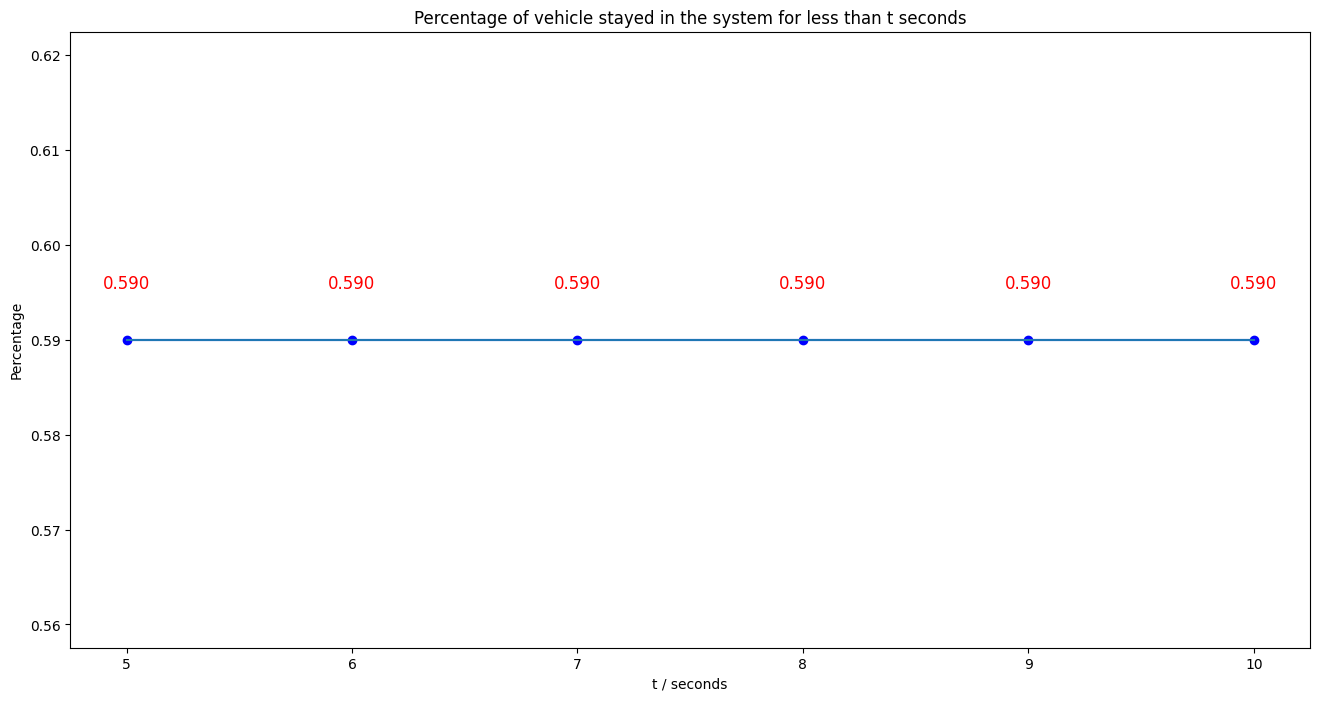

In [35]:
#### percentage of vehicle stayed in the system for t seconds

import matplotlib.pyplot as plt

shortdata = []
time = [5,6,7,8,9,10]
for t in time:
  shortdata.append(dataorilen-len(data[~data['timestamp'].apply(lambda x: at_least_one_min(x, t))]))

print(shortdata)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)

shortdata = np.array(shortdata)
time = np.array(time)


y_values = shortdata / dataorilen

ax.plot(time, y_values, marker='o', linestyle='-', color='b', label='Data Proportion')

for t_val, y_val in zip(time, y_values):
    ax.text(t_val, y_val + 0.005, f'{y_val:.3f}',
            ha='center', va='bottom', fontsize=12, color='red')

ax.plot(time,y_values)


ax.set_ylabel('Percentage')
ax.set_xlabel('t / seconds')
ax.set_title(r'Percentage of vehicle stayed in the system for less than t seconds')

plt.savefig('percentage stayed in.png')

fig.show()



In [36]:
def has_constant_x_position(x_pos):
    if len(x_pos) < 30:
        return False
    for i in range(len(x_pos) - 29):
        if abs(x_pos[i] - x_pos[i+29]) <= 1:
            return True
    return False


data = data[~data['x_position'].apply(has_constant_x_position)]

print(len(data))

28700


In [37]:
data1 = data[data.direction == 1]
data2 = data[data.direction == -1]
print(len(data1))
print(len(data))
print(len(data2))

13632
28700
15068


In [38]:

# def exit_at_62_3(x_pos):
#   tar = 62.3
#   ctr = 0
#   if abs(x_pos[-1] / 5280 - tar) < 0.1:
#       return True
#   return False

# data11 = data1[data1.x_position.apply(exit_at_62_3)]
# print(len(data11))

In [39]:
###### hard cleaning
#condition1 = data11['y_position'].apply(lambda lst: abs(lst[-1] - lst[0]) < 20)
condition2 = data1['y_position'].apply(lambda lst: (lst[-1] - lst[0]) < 10)
#filtered_data11 = data11[condition1 & condition2]
filtered_data11 = data1[condition2]

#data = data[~data['timestamp'].apply(lambda x: at_least_one_min(x, 10))]


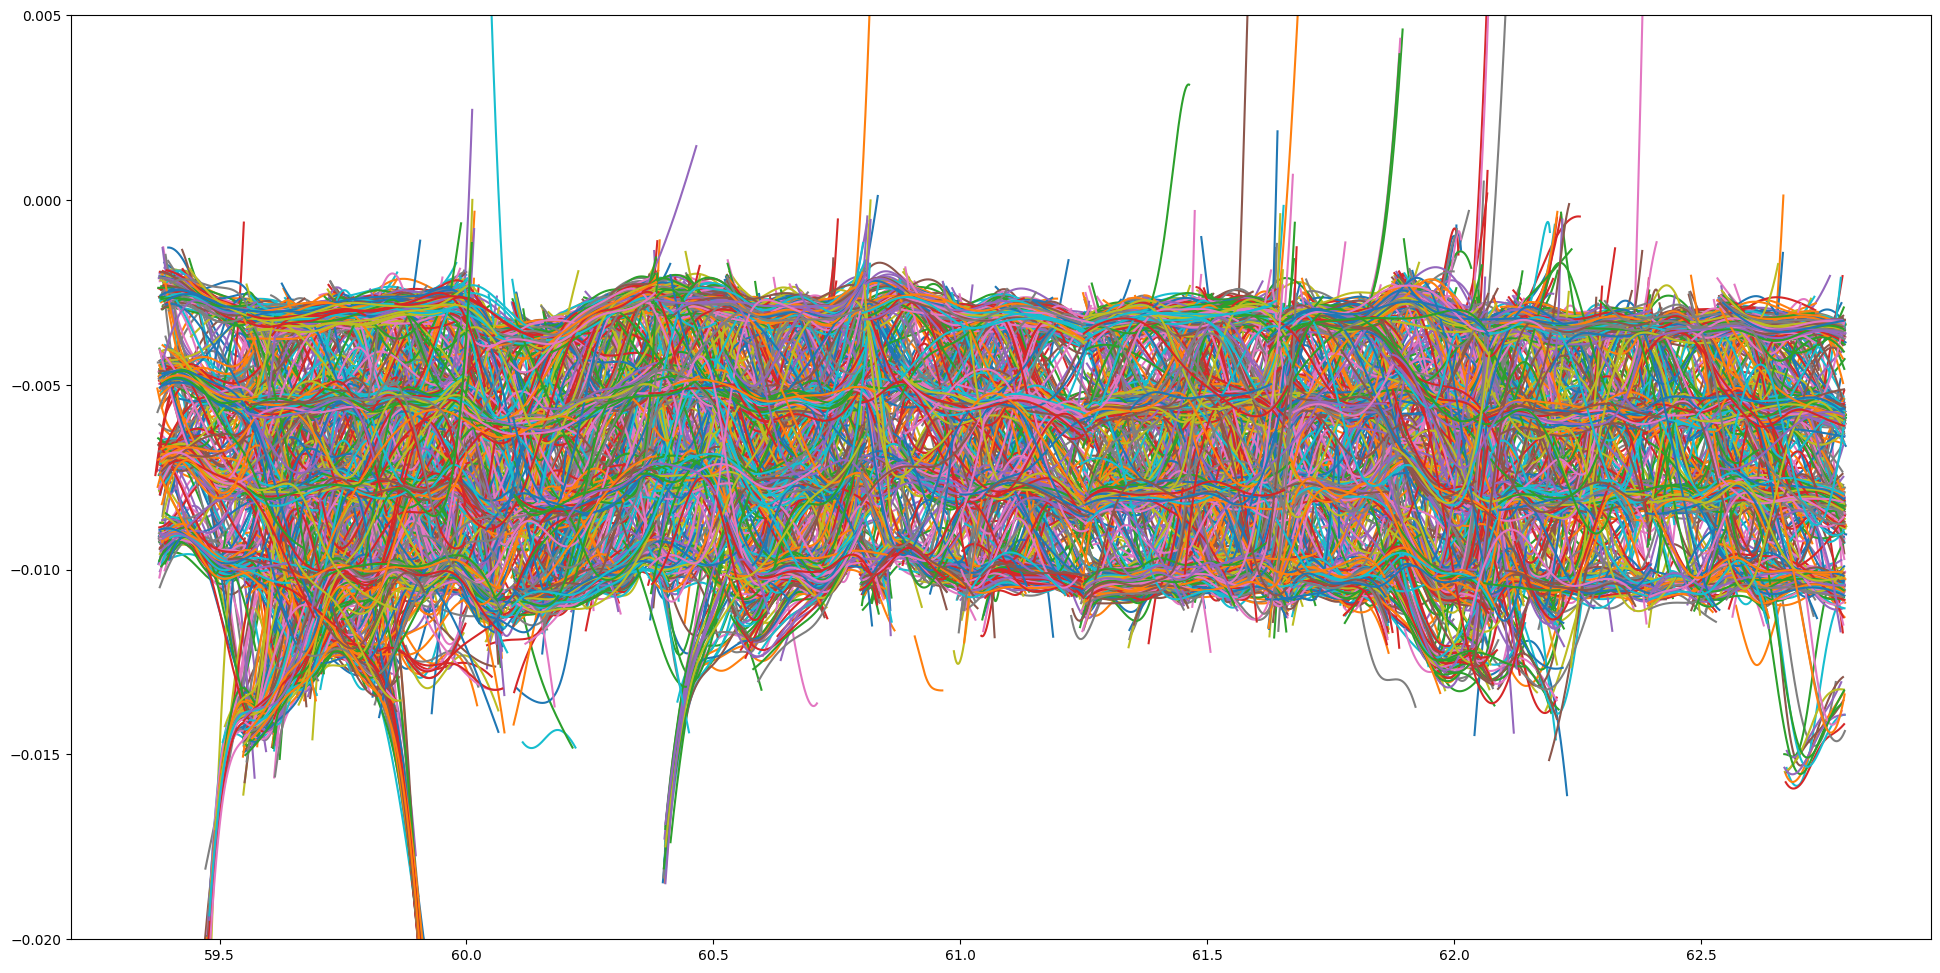

In [43]:
########### plot x vs. y
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)

for i in range(len(data1)):

    pos = np.array(data1.iloc[i].x_position)/5280
    y = np.array(data1.iloc[i].y_position)/5280

    ax.plot(pos, y)
#ax.set_xlim(62.1, 62.4)
ax.set_ylim(-0.02, 0.005)
plt.savefig('exit62.3.png')
fig.show()

<bound method Figure.show of <Figure size 2400x1200 with 1 Axes>>

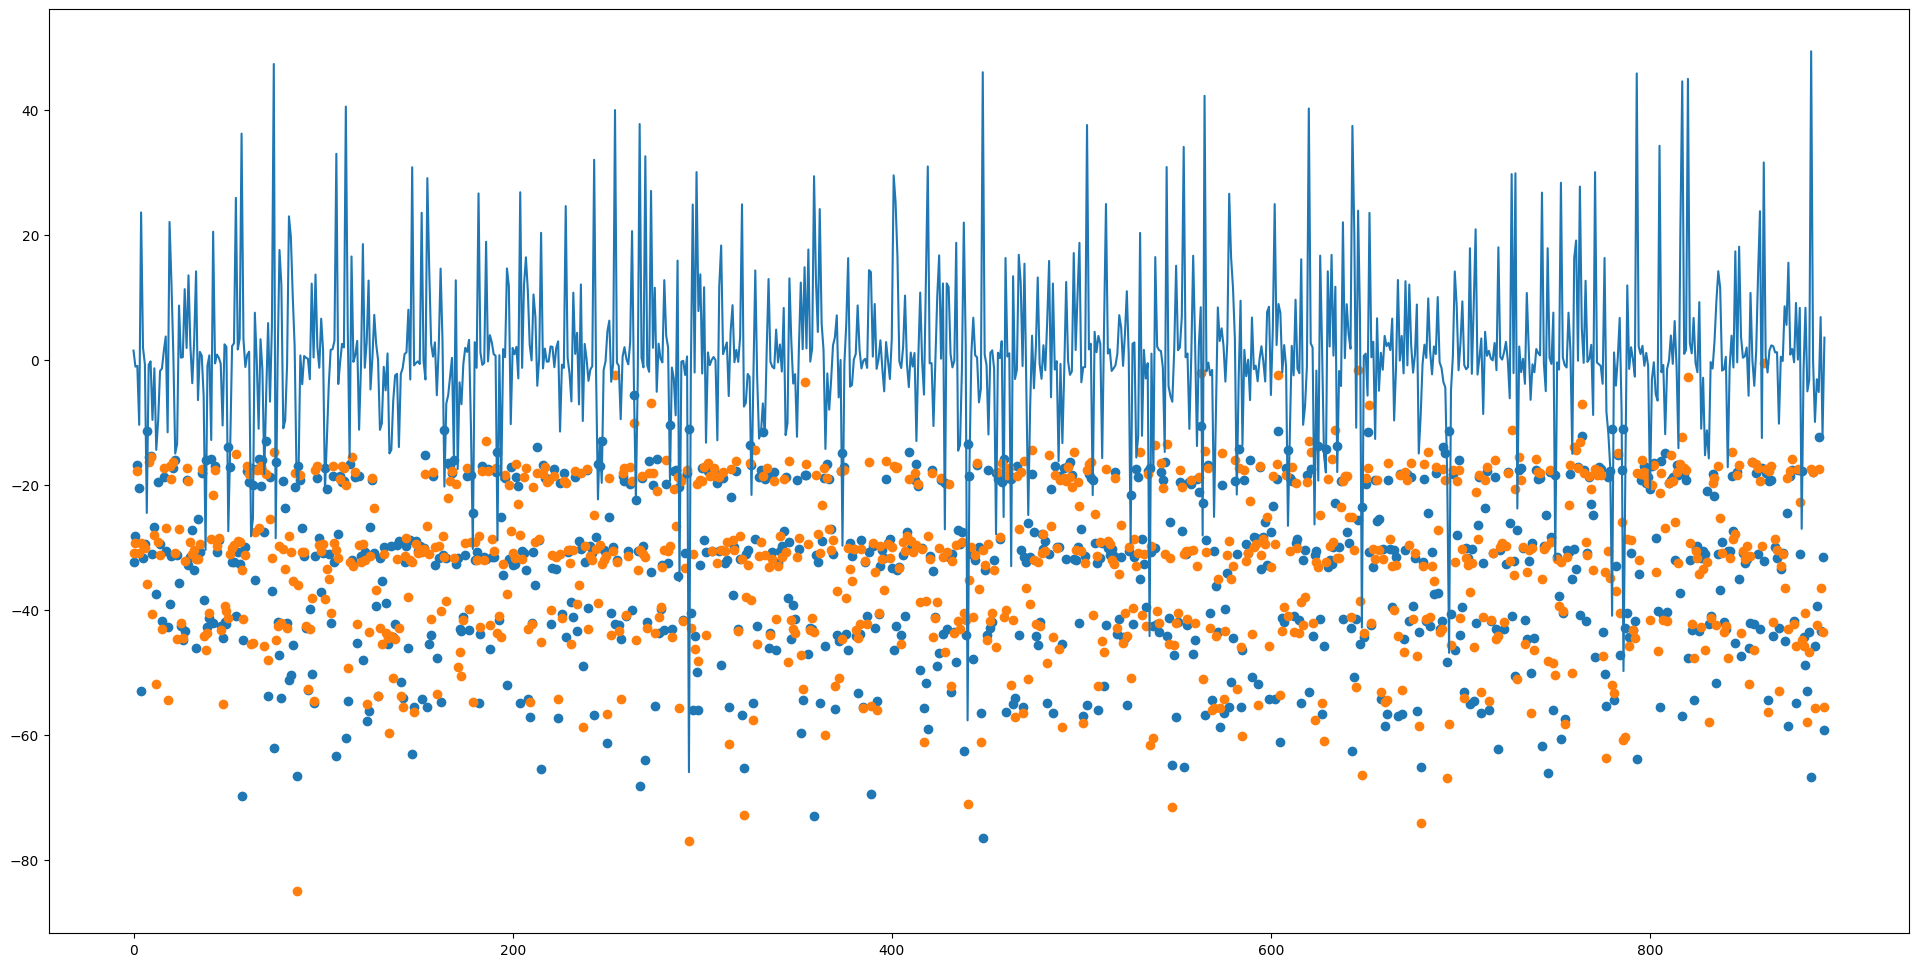

In [41]:
#### test part
data11.describe()
#data11.columns
ystart = []
yend = []
ydist = []
v = range(len(data11))
for i in v:
  ystart.append(data11.iloc[i].y_position[0])
  yend.append(data11.iloc[i].y_position[-1])
  ydist.append(data11.iloc[i].y_position[-1] - data11.iloc[i].y_position[0])
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
ax.scatter(v,ystart)
ax.scatter(v,yend)
ax.plot(v,ydist)
fig.show

# for i in range(20):
#   print(data11.iloc[i].y_position[0])
#   print(data11.iloc[i].y_position[-1])

In [42]:
########################segment
def segment_list(lst, segment_size):
    res = []
    for i in range(0, len(lst)+1, segment_size):
      if i+segment_size <= len(lst):
        res.append([lst[i],lst[i + segment_size]])
      else: break
    return res

time_list = np.arange(data.timestamp.explode().min(), data.timestamp.explode().max() + 1, step=1).tolist()
time_targets = np.arange(data.timestamp.explode().min(), data.timestamp.explode().max() + 1, step=100).tolist()
### density cal per 100 seconds
print(len(time_list))

segmented_time_list = segment_list(time_list, 100)
#flow cal each for 200s interval

#print(segmented_time_list[0])
space_list = np.arange(data["x_position"].explode().min(), data["x_position"].explode().max() + 1, step=1).tolist()
space_targets = np.arange(data["x_position"].explode().min(), data["x_position"].explode().max() + 1, step=500).tolist()
# flow cal per 1000 inches

segmented_space_list = segment_list(space_list, 1000)
# density cal each for 2000 inches interval

2353


KeyboardInterrupt: 

In [ ]:
density_list = []
flow_list = []
print(len(time_targets),len(space_targets),len(segmented_time_list),len(segmented_space_list))
for i in range(len(time_targets)):
   for item in segmented_space_list:
    density_list.append(calculate_density(data[data.direction == 1], item[0], item[1], time_targets[i]))

# start_time = time.time()
#
# #density_list.append(calculate_density(data, segmented_space_list[0][0], segmented_space_list[0][1], time_targets[0]))

with open("density_3.13_d=1.json", "w") as file:
    json.dump(density_list, file)

# end_time = time.time()

# elapsed_time = end_time - start_time



In [ ]:
for i in range(len(space_targets)):
  for item in segmented_time_list:
    flow_list.append( calculate_flow(data, space_targets[i], item[0], item[1]))


with open("flow_3.2.json", "w") as file:
    json.dump(flow_list, file)

In [ ]:
###reload data
with open('density_3.13_d=1.json', 'r', encoding='utf-8') as file:

    density_list =  json.load(file)
with open('flow_3.2.json', 'r', encoding='utf-8') as file:

    flow_list =  json.load(file)
###

In [ ]:
## data process

#print(len(density_list))#,len(flow_list))
#print(len(time_targets),len(space_targets))

d_l = list([] for i in range(int(len(density_list)/len(time_targets))))

f_l = list([] for i in range(int(len(flow_list)/len(space_targets))))

for i in range(len(density_list)):
  d_l[math.floor(i/(len(time_targets)))].append(density_list[i])

for i in range(len(flow_list)):
  f_l[math.floor(i/len(space_targets))].append(flow_list[i])


In [ ]:
################  x pos vs time
# with open('Nov22small.json', 'r') as file:
#     data = json.load(file)

#timestamps = [datetime.datetime.fromtimestamp(t).time().strftime("%H:%M:%S.%f")[:-3] for t in data.timestamp[0]]
start_time = datetime.datetime(2022, 11, 22, 7, 0)
start_time = start_time.timestamp()

fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)

for i in range(min(70000, len(data))):
    #i = j * 10+3
    if data.iloc[i].direction == 1:
        continue
    pos = np.array(data.iloc[i].x_position)/5280
    timestamps = np.array(data.iloc[i].timestamp) - start_time
    ax.plot(timestamps, pos)
plt.savefig('x_pos vs time.png')
fig.show()

In [ ]:
## graphing
#print(segmented_time_list )
start_time = datetime.datetime(2022, 11, 22, 7, 0)

tstamps = [datetime.datetime.fromtimestamp(t[0]).time().strftime("%H:%M:%S.%f")[:-3] for t in segmented_time_list ]

x = range(len(d_l))
t = time_targets
T,X = np.meshgrid(t,x)

space = space_targets
print(space)
time = range(len(f_l))
sp,ti = np.meshgrid(space, time)
#print(time)


##draw

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

#：rho(x, t) density
c = ax1.contourf( T,X, d_l, levels=50, cmap='viridis')
ax1.set_ylabel('x / miles')
ax1.set_xlabel('t / seconds')
ax1.set_title(r'$\hat{\rho}(x,t)$')

yticks = x
yticklabels =  [np.around(i / 5280,2) for i,y in segmented_space_list ]

ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)
fig.colorbar(c, ax=ax1,label='Intensity')



# ：u(x, t) : flow
c = ax2.contourf(ti, sp, f_l, levels=50, cmap='plasma')
ax2.set_ylabel('x / miles')
ax2.set_xlabel('t ')
ax2.set_title(r'$\hat{u}(x,t)$')

xticks = time
xticklabels = tstamps


ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
ax2.set_yticks(space)
yticklabels2 = [np.around(i / 5280,2) for i in space_targets ]
ax2.set_yticklabels(yticklabels2)
fig.colorbar(c, ax=ax2,label='Intensity')


plt.tight_layout()

plt.savefig('3.13_d_100s_1000in_f_100s_500in.png')
plt.show()

In [ ]:
def load_ramp_data():
  ramp_data = read_csv(ramp_and_landmark_layer.csv)
def create_ramp_list(ramp_data):
  x_pos_eb_ramps = []

#Direction "EB"=east bound, "WB"= west bound
#Boarding "on" = "off"
def ramp_loaded_vehicles(data, ramp_loc, start_time, end_time, direction = "EB", boarding = "on", buffer = 50):
  change_count = 0
  for i in range(len(data)):
    x_positions = data.iloc[i].x_position
    timestamps = data.iloc[i].timestamp
    y_positions = data.iloc[i].x_position
    j = 0
    start_index = -1
    end_index = -1
    while j < len(timestamps) - 1:
      if (start_index == -1) and timestamps[j] >= start_time:
        start_index = j-1
      if timestamps[j] >= end_time:
        end_index = j
      if start_index != -1 and end_index != -1:
        break
      if start_index == -1:
        continue
      if end_index == -1:
        end_index = len(timestamps) - 1


    match direction:
      case "EB":
        match boarding:
          case "on":
            if x_positions[start_index] <= ramp_loc + buffer <= x_positions[end_index]:
              if x_positions[start_index] >= ramp_loc - buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc + buffer, lo=start_index, hi=end_index)
                if(-36<=y_positions[ramp_buffer_index] <= -24):
                  change_count+=1
           # in correct lane
          case "off":
            if x_positions[start_index] <= ramp_loc - buffer <= x_positions[end_index]:
              if x_positions[end_index] <= ramp_loc + buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc - buffer, lo=start_index, hi=end_index)
                if(-36<=y_positions[ramp_buffer_index] <= -24):
                  change_count+=1
           # in correct lane
      case "WB":
        match boarding:
          case "on":
            if x_positions[start_index] <= ramp_loc - buffer <= x_positions[end_index]:
              if x_positions[start_index] <= ramp_loc + buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc - buffer, lo=start_index, hi=end_index)
                if(36 >= y_positions[ramp_buffer_index] >= 24):
                  change_count+=1
          case "off":
            if x_positions[start_index] <= ramp_loc + buffer <= x_positions[end_index]:
              if x_positions[end_index] >= ramp_loc - buffer:
                ramp_buffer_index = bisect.bisect_left(x_positions, ramp_loc + buffer, lo=start_index, hi=end_index)
                if(36 >= y_positions[ramp_buffer_index] >= 24):
                  change_count+=1
  return change_count


In [ ]:
def ramp_loaded_vehicles_alt_count(data,ramp_loc,start_time,end_time,direction="EB",buffer=50):
  ramp_before = 0
  ramp_after = 0
  for i in range(len(data)):
    x_positions = data.iloc[i].x_position
    timestamps = data.iloc[i].timestamp
    y_positions = data.iloc[i].x_position
    j = 0
    start_index = -1
    end_index = -1
    while j < len(timestamps) - 1:
      if (start_index == -1) and timestamps[j] >= start_time:
        start_index = j-1
      if timestamps[j] >= end_time:
        end_index = j
      if start_index != -1 and end_index != -1:
        break
      if start_index == -1:
        continue
      if end_index == -1:
        end_index = len(timestamps) - 1

    match direction:
      case "EB":
        if x_positions["start_index"] <= ramp_loc - buffer and y_positions["start_index"] < 0:
          ramp_before+=1
        if x_positions["end_index"] >= ramp_loc + buffer and y_positions["start_index"] < 0:
          ramp_after+=1
      case "WB":
        if x_positions["start_index"] >= ramp_loc + buffer and y_positions["start_index"] > 0:
          ramp_before+=1
        if x_positions["end_index"] <= ramp_loc - buffer and y_positions["start_index"] > 0:
          ramp_after+=1
  return ramp_before - ramp_after


In [ ]:
print(segmented_time_list)
result = ramp_loaded_vehicles(data, 60*5280, segmented_time_list[0][0], segmented_time_list[0][1])

In [ ]:
result2 = ramp_loaded_vehicles_alt_count(data, 60*5280, segmented_time_list[0][0], segmented_time_list[0][1])